# Convolutional Neural Network (1of1)

**Notes about this specific notebook**

This notebook only ran on the ransomware images!

This notebook uses data augmentation to improve the generalizability of the model. 

Uses rgb, 64x64 images with LeakyReLU activation.

Weights are not included! 

# CHANGE

_____________________________________________________________________

In [240]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'grayscale'

# Batch size
batch_size = 64

# Number of epochs
epoch_t = 25

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

# Division of the training vs. test set (in %)
test_size = 0.3

# Weight factor (1 is perfect reverse)
wf = 0.5

_____________________________________________________________________

In [241]:
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


In [242]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn import metrics
import sys
import os
from math import log
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

In [243]:
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
print(is_cuda_gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [244]:
im_si = (ih, iw)

if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

Create new directory for saving output files

In [245]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/cnn"
    for files in os.listdir(dir):
        if "cnn" in files:
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: cnn-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/cnn/cnn-local-v{new_vnum:03}"
    os.makedirs(new_dir)

15 matches(es) found
--------------
New folder name: cnn-local-v016
--------------


**Data**


In [246]:
if cenv == 0:
    path_root = "/kaggle/input/thesis-data"

if cenv == 1:
    path_root = "C:/Users/Max/Documents/image_data/data_wo_benign"

In [247]:
t_datagen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=.01,
    rescale=1/255,
    validation_split=0.3)

In [248]:
train = t_datagen.flow_from_directory(
    directory     = path_root, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic',
    subset='training',
    seed = 123
)

Found 8780 images belonging to 10 classes.


In [249]:
v_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.3)

In [337]:
test = v_datagen.flow_from_directory(
    directory     = path_root, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic',
    subset='validation',
    seed = 123,
    shuffle = False
)

Found 3756 images belonging to 10 classes.


In [251]:
train.class_indices

{'BetterSurf': 0,
 'Eksor.A': 1,
 'Obfuscator.AFQ': 2,
 'Occamy.C': 3,
 'OnLineGames.CTB': 4,
 'Reveton.A': 5,
 'Sfone': 6,
 'VB.IL': 7,
 'Zbot': 8,
 'Zbot!CI': 9}

In [336]:
print(test.classes[1900])

3


In [252]:
num_samples = train.samples

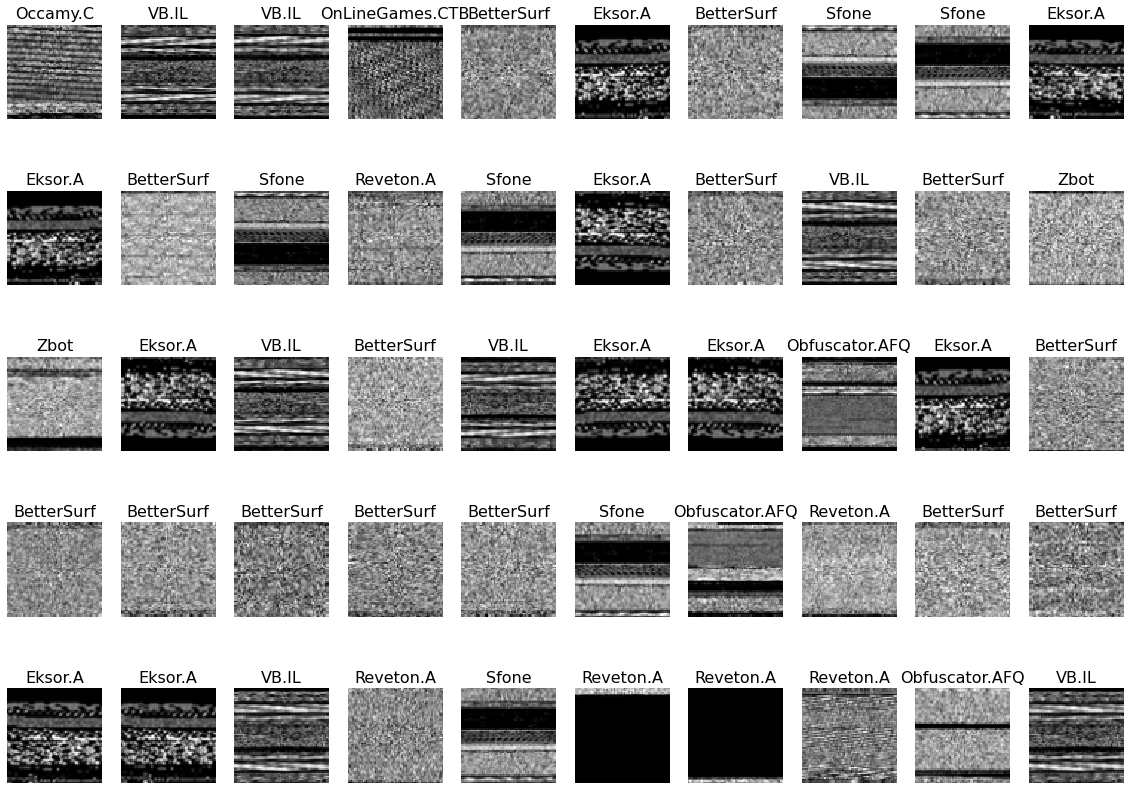

In [253]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != chnum):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], cmap = 'gray',interpolation=None if interp else 'none')
        
plots(imgs, titles = labels)

In [254]:
classes = batches.class_indices.keys()

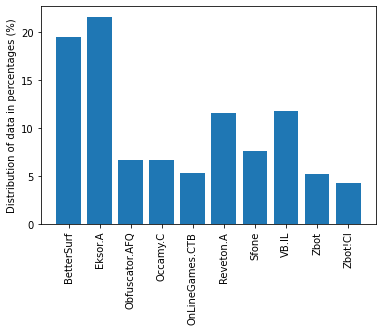

In [255]:
perc = (sum(labels)/labels.shape[0])*100
plt.xticks(rotation='vertical')
plt.bar(classes,perc)
plt.ylabel('Distribution of data in percentages (%)')

if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight')

In [256]:
# Train and Test
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=test_size)
X_train.shape
X_test.shape
y_train.shape
y_test.shape

(3761, 10)

In [257]:
trainsize = len(X_train)
testsize = len(X_test)

print(f"Size of training data: {trainsize} | Shape of training data {X_train.shape}")
print(f"Size of training data: {testsize}  | Shape of training data {X_test.shape}")
print(f"Shape of training labels {y_train.shape}")
print(f"Shape of training labels {y_test.shape}")

Size of training data: 8775 | Shape of training data (8775, 64, 64, 1)
Size of training data: 3761  | Shape of training data (3761, 64, 64, 1)
Shape of training labels (8775, 10)
Shape of training labels (3761, 10)


In [258]:
def my_fmt(x):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)
total = trainsize + testsize

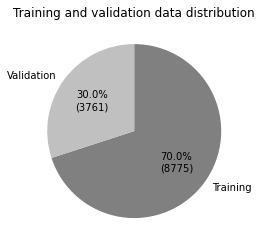

In [259]:
plt.pie(
    [trainsize, testsize], 
    labels = ["Training", "Validation"], 
    startangle=90, 
    counterclock=False, 
    autopct=my_fmt,
    colors = ['gray', 'silver']
)

plt.title("Training and validation data distribution")

if cenv == 0:
    plt.savefig("train_test_dist.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/train_test_dist.png", bbox_inches = 'tight')

# Convolutional Neural Network
We will now build our **CNN** model using Keras. This model will have the following layers :

* **Convolutional Layer** : 30 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **Convolutional Layer** : 15 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **DropOut Layer** : Dropping 25% of neurons.
* **Flatten Layer**
* **Dense/Fully Connected Layer** : 128 Neurons, Relu activation function
* **DropOut Layer** : Dropping 50% of neurons.
* **Dense/Fully Connected Layer** : 50 Neurons, Softmax activation function
* **Dense/Fully Connected Layer** : num_class Neurons, Softmax activation function

**Input shape** : 64 * 64* 3

In [260]:
import keras
from keras.models import Sequential, Input, Model, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

Retrieve the number of classes in our dataset

In [261]:
num_classes = labels[1].shape[0]
print("The number of classes in our dataset: ", num_classes)

The number of classes in our dataset:  10


Building the model

In [262]:
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(ih,iw,chnum)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='LeakyReLU'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='LeakyReLU'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='LeakyReLU'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [263]:
Malware_model = malware_model()
Malware_model.summary() # Overview of the CNN model

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 62, 62, 30)        300       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 30)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 29, 29, 15)        4065      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 15)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 15)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2940)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)              

In [264]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
if cenv == 0:
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
if cenv == 1:
    checkpoint = ModelCheckpoint(f'{new_dir}/model.h5', verbose=1, save_best_only=True)


In [265]:
history = Malware_model.fit(
    train,
    steps_per_epoch=num_samples//batch_size,
    epochs=epoch_t,
    callbacks = [anne, checkpoint],
    validation_data=test,
    validation_steps=test.samples//batch_size) # The actual computation of the CNN

Epoch 1/25
137/137 [==============================] - 10s 72ms/step - loss: 0.8907 - accuracy: 0.7089 - val_loss: 0.6783 - val_accuracy: 0.7621

Epoch 00001: val_loss improved from inf to 0.67831, saving model to /Users/Max/Documents/GitHub/cnn/cnn-local-v016\model.h5
Epoch 2/25
137/137 [==============================] - 10s 76ms/step - loss: 0.5329 - accuracy: 0.8238 - val_loss: 0.4535 - val_accuracy: 0.8408

Epoch 00002: val_loss improved from 0.67831 to 0.45345, saving model to /Users/Max/Documents/GitHub/cnn/cnn-local-v016\model.h5
Epoch 3/25
137/137 [==============================] - 10s 71ms/step - loss: 0.4496 - accuracy: 0.8512 - val_loss: 0.4012 - val_accuracy: 0.8623

Epoch 00003: val_loss improved from 0.45345 to 0.40122, saving model to /Users/Max/Documents/GitHub/cnn/cnn-local-v016\model.h5
Epoch 4/25
137/137 [==============================] - 10s 71ms/step - loss: 0.4086 - accuracy: 0.8634 - val_loss: 0.4272 - val_accuracy: 0.8605

Epoch 00004: val_loss did not improve fr

# Evaluating performance

In [266]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

In [267]:
if cenv == 0:
    best_model = load_model("/kaggle/working/model.h5")
if cenv == 1:
    best_model = load_model(f"{new_dir}/model.h5")

In [283]:
scores = best_model.evaluate(test, steps = test.samples//batch_size) # Testing the CNN on the test set
print(f"Overall CNN Accuracy: {scores[1]}\n(The number of correct predictions divided by the number of total predictions)")

58/58 [==============================] - 2s 39ms/step - loss: 0.2737 - accuracy: 0.9192
Overall CNN Accuracy: 0.9191810488700867
(The number of correct predictions divided by the number of total predictions)


In [284]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['Valididation accuracy', round(scores[1],4)])
t.add_row(['Validation loss', round(scores[0],4)])
t.header = True
t.align = "l"
t.title = "Performance of multi-class classification - CNN"
print(t)

+-------------------------------------------------+
| Performance of multi-class classification - CNN |
+-------------------------------+-----------------+
| Metric                        | Performance     |
+-------------------------------+-----------------+
| Valididation accuracy         | 0.9192          |
| Validation loss               | 0.2737          |
+-------------------------------+-----------------+


In [285]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

# Evaluating overfitting and other model performance measures

In [286]:
def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, epoch_t + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    if cenv == 0:
        plt.savefig(f"cnn_model_{metric_name}.png", bbox_inches = 'tight')
    if cenv == 1:
        plt.savefig(f"{new_dir}/cnn_model_{metric_name}.png", bbox_inches = 'tight')

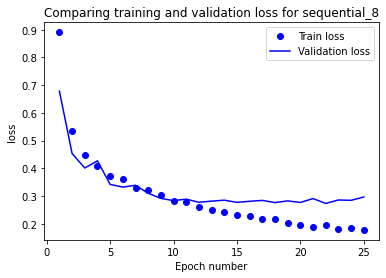

In [287]:
eval_metric(Malware_model, history, 'loss')

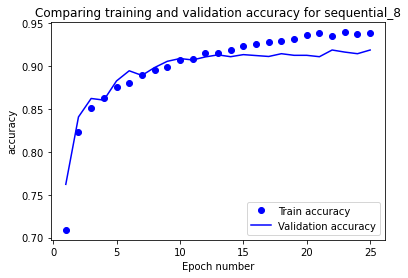

In [288]:
eval_metric(Malware_model, history, 'accuracy')

# Confusion Matrix
Analysing the results

In [338]:
y_pred = np.argmax(best_model.predict(test, steps= test.samples//batch_size+1), axis=-1)
y_pred

array([0, 0, 0, ..., 3, 8, 9], dtype=int64)

In [339]:
true_classes = test.classes
class_labels = list(test.class_indices.keys())

In [340]:
report = metrics.classification_report(true_classes, y_pred, target_names=class_labels)

In [341]:
print(report)

                 precision    recall  f1-score   support

     BetterSurf       0.87      1.00      0.93       730
        Eksor.A       1.00      1.00      1.00       810
 Obfuscator.AFQ       0.98      1.00      0.99       250
       Occamy.C       0.64      0.33      0.44       251
OnLineGames.CTB       0.98      0.98      0.98       200
      Reveton.A       0.87      0.94      0.90       433
          Sfone       1.00      1.00      1.00       286
          VB.IL       1.00      1.00      1.00       443
           Zbot       0.77      0.65      0.71       194
        Zbot!CI       0.73      0.76      0.74       159

       accuracy                           0.92      3756
      macro avg       0.88      0.87      0.87      3756
   weighted avg       0.91      0.92      0.91      3756



In [342]:
y_test2 = test.classes
y_test2

array([0, 0, 0, ..., 9, 9, 9])

In [343]:
c_matrix = metrics.confusion_matrix(y_test2, y_pred)
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if cenv == 0:
        plt.savefig("multi_class_cmatrix.png", bbox_inches = 'tight')
    if cenv == 1:
        plt.savefig(f"{new_dir}/multi_class_cmatrix.png", bbox_inches = 'tight')

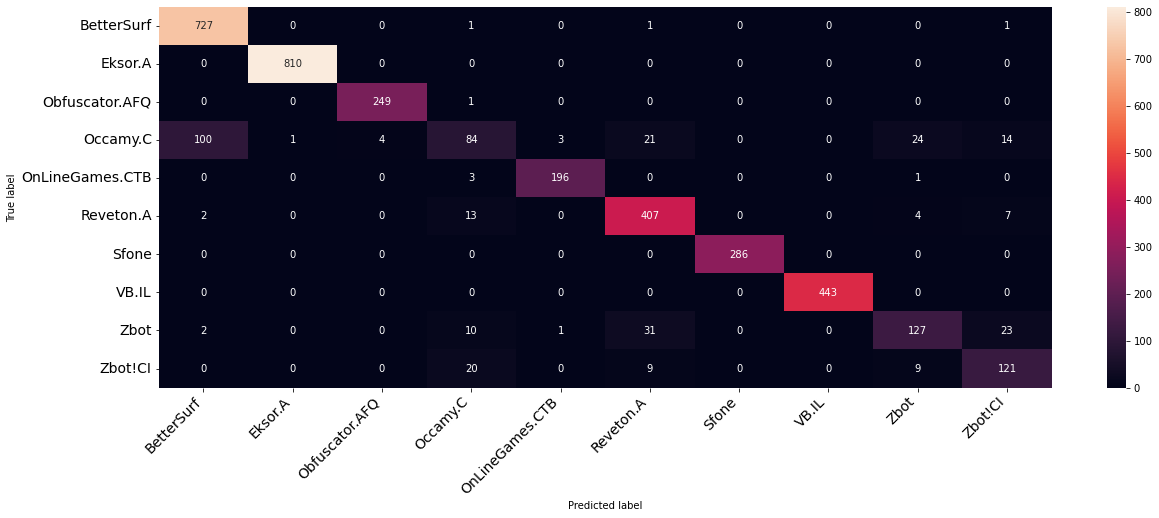

In [344]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

# Detection Measurement
y_predbin and y_testbin are the binary classification arrays. 0 = ransomware and 1 = benign

In [293]:
y_predbin = [] 
y_truebin = []
for count, value in enumerate(y_test2):
    if y_test2[count] in range(10): # range(10) is 0 to 9
        y_truebin.append(0)
    else: y_truebin.append(1)
    
    if y_pred[count] in range(10):
        y_predbin.append(0)
    else: y_predbin.append(1)
    
    continue
print(len(y_truebin))
print(len(y_predbin))

3761
3761


In [294]:
binary_labels = np.array([])
for count, value in enumerate(labels):
    if labels[count].argmax() in range(10): # range(10) is 0 to 9
        binary_labels = np.append(binary_labels, "Ransomware")
    else: binary_labels = np.append(binary_labels, "Benign")
    continue
print(binary_labels)
rw_count = np.count_nonzero(binary_labels == "Ransomware")
bn_count = np.count_nonzero(binary_labels == "Benign")
print(f"Ransomware Occurences: {rw_count}, Benign Occurences: {bn_count}")

['Ransomware' 'Ransomware' 'Ransomware' ... 'Ransomware' 'Ransomware'
 'Ransomware']
Ransomware Occurences: 12536, Benign Occurences: 0


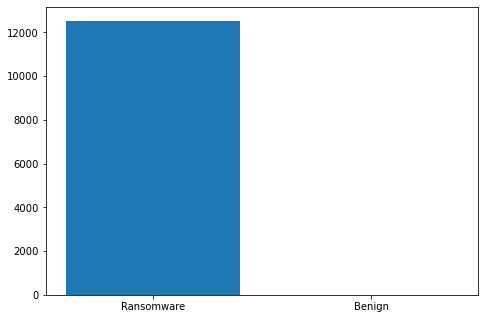

In [295]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_lab = ['Ransomware', 'Benign']
y_lab = [rw_count, bn_count]
ax.bar(x_lab, y_lab)
if cenv == 0:
    plt.savefig("data_dist.png.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist.png", bbox_inches = 'tight')

In [296]:
c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)
def confusion_matrix_bin(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_bin, columns=class_names_bin, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if cenv == 0:
        plt.savefig("bin_class_cmatrix.png", bbox_inches = 'tight')
    if cenv == 1:
        plt.savefig(f"{new_dir}/bin_class_cmatrix.png", bbox_inches = 'tight')

In [297]:
class_names_bin= ("ransomware", "benign")
confusion_matrix_bin(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)

ValueError: Shape of passed values is (1, 1), indices imply (2, 2)

**True Positive Rate**

In [ ]:
TPR = c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1]) #True Positive Rate

**Accuracy**

In [ ]:
ACC = accuracy_score(y_truebin, y_predbin) # Accuracy

**F1 Score**

In [ ]:
F1 = f1_score(y_truebin, y_predbin, labels=0) # F1 Score

**Matthews Correlation Coefficient**

In [ ]:
MCC = matthews_corrcoef(y_truebin, y_predbin) # Matthews Correlation Coefficient

**Show Performance of CNN**

In [ ]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['True Positive Rate', round(TPR,4)])
t.add_row(['Accuracy', round(ACC,4)])
t.add_row(['F1 Score', round(F1,4)])
t.add_row(['Matthews Correlation Coefficient', round(MCC,4)])
t.header = True
t.align = "l"
t.title = "Performance of CNN"
print(t)

In [ ]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('bin_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/bin_performance_table.txt', 'w') as f:
        f.write(table)
